# Libraries and Global Settings

In [9]:
import pandas as pd  # u.a. verwendet um DataFrames zu generieren und zu bearbeiten
import numpy as np
import json  # Bearbeitung von json-Files
import seaborn as sns # Visualisierungen 
from matplotlib import pyplot as plt
import warnings # Funktionalität zur Unterdrückung von Warnungen
warnings.filterwarnings('ignore')


In [10]:
%%html
<style>
table {float:left}
</style>

# Business Understanding

## Business Case Definition and Understanding

This project is part of the module "Machine Learning" (ML) at the Hochschule der Medien Stuttgart in the summer semster 2020.  
In this case we have to realize a project in the context of ML. 
The topic of this project comprises the analysis of the air quality in the center of Stuttgart, especially at the measuring point Stuttgart-Neckartor. 

## Goal Definition

The goal of this project is to analyze the air pollution caused by particulates (Feinstaub) in conjuction with other air specific and traffic based features.  
Furthermore, we would like to detemine if a prediction of the air pollution based on these features is possible.  
The use case of this prediction is to deliver valuable information for the warning system in Stuttgart. 

## Metrics Specification for Performance Measuring

The data samples consist of the target values for particulates and the features used as input parameters for the forecasting of our target values.  

| Column name | Additional information | Description |  Used As | 
| :------- | :------: | :------- | :-------  |
| Datum		 |  |  Datum | Feature | 
| Temp. (°C)	| Mittel	| Lufttemperatur|  Feature |
| Temp. (°C)	| Max	| Lufttemperatur|  Feature |
| Temp. (°C)	| Min	| Lufttemperatur|  Feature |
| Feuchte (%)	| Mittel	| Relative Luftfeuchte|  Feature |
| WG (m/s)	| Mittel	| Windgeschwindigkeit|  Feature |
| WG (m/s)	| Max	| Windgeschwindigkeit|  Feature |
| WR (Grad)	| Mittel	| Windrichtung|  Feature |
| Druck (hPa)	| Mittel	| Absoluter Luftdruck|  Feature |
| Niederschlag (l/m²)	| Summe	| Niederschlag|  Feature |
| Globalstr. (W/m²)	| Mittel	| Globalstrahlung|  Feature |
| Str.-Bilanz (W/m²)	| Mittel	| Strahlungsbilanz|  Feature |
| UVA-Str. (W/m²)	| Mittel	| UV-A Strahlung|  Feature |
| UVB-Str. (W/m²)	| Mittel	| UV-B  Strahlung|  Feature |
| NO (µg/m³)	| Mittel	| Stickstoffmonoxid|  Feature |
| NO2 (µg/m³)	| Mittel	| Stickstoffdioxid|  Feature |
| O3 (µg/m³)	| Mittel	| Ozon|  Feature |
| PM10 (µg/m³)	| Mittel	| Feinstaub (PM10)| Outcome Variable |
| PM2,5 (µg/m³)	| Mittel	| Feinstaub (PM2.5)| not relevant |
| Verkehraufkommen	| Summe	| Verkehraufkommen |  Feature |



# Data Understanding

data must be gathered, accessed, understood and described. Quantitiy and qualitity of the data must be assessed on a high-level.

## Data Gathering

Air data:

In [11]:
# https://www.stadtklima-stuttgart.de/index.php?luft_messdaten_download

Traffic data:

In [ ]:
# https://www.bast.de/BASt_2017/DE/Verkehrstechnik/Fachthemen/v2-verkehrszaehlung/Aktuell/zaehl_aktuell_node.html?nn=1819516&cms_detail=8440&cms_map=0

## Data Access

In [2]:
# define funktion to import each ExcelTab in one pandas dataframe
def excelImport(list_1, path_1, list_2, path_2):
    for i in list_1:
        if i == 2000:
            df = pd.read_excel(path_1, sheet_name=str(i), header=6)
            df = df.dropna(subset=['Datum'])
        else:
            df_temp = pd.read_excel(path_1, sheet_name=str(i), header=6)
            df_temp = df_temp.dropna(subset=['Datum'])
            df = df.append(df_temp, sort=False, ignore_index=True)
        #print(str(i))
    for j in list_2:
        df_temp2 = pd.read_excel(path_2, sheet_name=j, header=6)
        df_temp2 = df_temp2.dropna(subset=['Datum'])
        df = df.append(df_temp2, sort=False, ignore_index=True)
        #print(j)
    return df

In [3]:
list_1 = list(range(2000, 2020, 1))
list_2 = ["Jan. 2020", "Feb. 2020", "März 2020", "April 2020", "Mai 2020"]
path_1 = "Data/SZ-Tages-Werte-2000-2019.xlsx"
path_2 = "Data/S-Mitte-SZ-Tages-Werte-2020.xlsx"

df_ges = excelImport(list_1, path_1, list_2, path_2)

In [4]:
df_ges.head(5)

,Datum,Temp. (°C),Temp. (°C).1,Temp. (°C).2,Feuchte (%),WG (m/s),WG (m/s).1,WR (Grad),Druck (hPa),Globalstr. (W/m²),...,NO (µg/m³),NO2 (µg/m³),O3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Niederschlag (l/m²),Str.-Bilanz (W/m²),PM10 (µg/m³),PM2.5 (µg/m³),"PM2,5 (µg/m³)"
0,2000-01-01,3.718,5.7,2.138,86.83,1.9599,7.45,234.923,991.8,NaN,...,NaN,NaN,13.6,10.38,0.9109,NaN,NaN,NaN,NaN,NaN
1,2000-01-02,3.848,6.706,1.299,90.69,2.17291,7.891,222.511,996.9,NaN,...,NaN,NaN,16.91,10.74,0.887,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,1.463,2.706,0.4088,88.48,2.29521,6.03,220.181,996.2,NaN,...,NaN,NaN,15.4,10.29,0.8394,NaN,NaN,NaN,NaN,NaN
3,2000-01-04,4.934,7.747,0.8828,77.37,3.57498,9.703,220.885,989.9,NaN,...,NaN,NaN,22.43,13.42,0.7822,NaN,NaN,NaN,NaN,NaN
4,2000-01-05,6.917,10.07,2.034,83.52,2.23721,9.115,220.554,989.7,NaN,...,NaN,NaN,16.03,14.27,1.189,NaN,NaN,NaN,NaN,NaN


## Data Description and Understanding

### Data Quantity

### Data Quality

# Data Preparation

## Data Investigation

### Data Visualization

ValueError: zero-size array to reduction operation fmin which has no identity

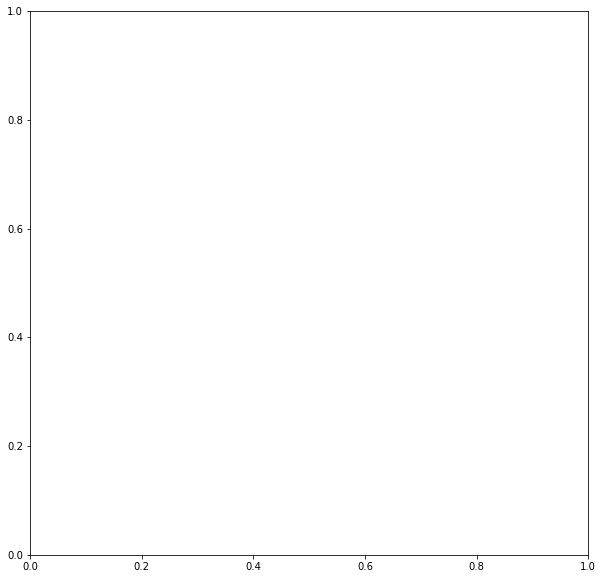

In [5]:
from utils import heatMap
heatMap(df_ges)

In [8]:
#sns.pairplot(data=df_outer)

In [6]:
sns.catplot(x='Year',y='Crime Index',kind='box',data=df_ges)

ValueError: Could not interpret input 'Year'

### Descriptive Statistics

### Detection of Missing Values

Deletion of all missing values:

In [10]:
df_outer=df_outer.dropna()

### Outlier Detection and Handling

### Definition of Sampling Rates

### Features Selection

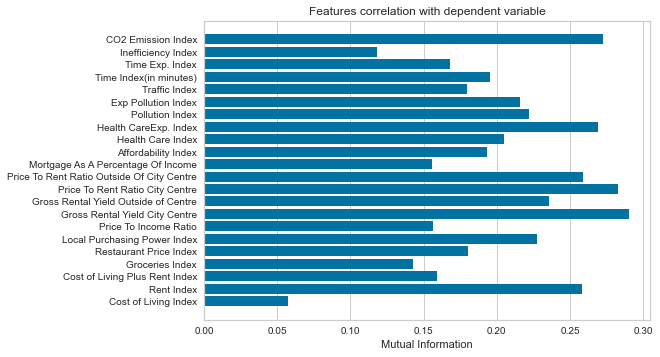

In [11]:
from sklearn import datasets
from yellowbrick.target import FeatureCorrelation

X, y = df_outer.drop(['Crime Index', 'Country', 'Year', 'Safety Index'], axis=1).to_numpy(), df_outer['Crime Index'].to_numpy()

# Create a list of the feature names
features = np.array(list(df_outer.drop(['Crime Index', 'Country', 'Year', 'Safety Index'], axis=1)))

# Create a list of the discrete features
discrete = [False for _ in range(len(features))]
discrete[1] = True

# Instantiate the visualizer
visualizer = FeatureCorrelation(method='mutual_info-regression', labels=features)

visualizer.fit(X, y, discrete_features=discrete, random_state=0)
visualizer.show()

# Modeling

## Data Preparation

### Data Scaling and Normalization

### Split Data into Training and Validation Samples

## Alogrithms Selection

## Baseline Models

## Deep Learning Models

## Hyperparamters Optimization

## Evaluation

### Model Evaluation (Performance)

#### Training Phase

#### Testing Phase

# Projekt Evaluation

# Deployment

In the first phase of CRISP the overall business-case, which shall be supported by the data mining process must be clearly defined and understood. Then the goal of the data mining project itself must be defined. This includes the specification of metrics for measuring the performance of the data mining project.

In the second phase data must be gathered, accessed, understood and described. Quantitiy and qualitity of the data must be assessed on a high-level.

In the third phase data must be investigated and understood more thoroughly. Common means for understanding data are e.g. visualization and the calculation of simple statistics. Outliers must be detected and processed, sampling rates must be determined, features must be selected and eventually be transformed to other formats.

In the modelling phase various algorithms and their hyperparameters are selected and applied. Their performance on the given data is determined in the evaluation phase.

The output of the evaluation is usually fed back to the first phases (business- and data-understanding). Applying this feedback the techniques in the overall process are adapted and optimized. Usually only after several iterations of this process the evaluation yields good results and the project can be deployed.